In [1]:
import pandas as pd
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 350)
import seaborn as sns

If we go by the books, the standard ways to deal with missing data are either:

Remove rows including missing values

Replace them with some value. This can be as easy as just using that variable average/mode, it can mean building a model to predict the missing value and replace it with the prediction, as well as countless small variations of those approaches. But at the end of the day, regardless of the actual approach we use to impute missing values, the idea is the same:

Replace them with the value that we think it was the most likely to happen if that value hadn’t been missing

In practice, none of those approaches would work if we are dealing with consumer data. Consumer data are full of missing values. Think about our profiles on FB, LinkedIn, Airbnb, etc. How many fields there are? And how many did 
we actually fill out? Anything that we did not fill out is a missing value in the corresponding table.

The high high majority of missing values in tech companies come from the fact that the user has chosen to not give that kind of information: by not filling out her profile, or by changing her privacy settings, or even by deleting her cookies. And that’s crucial information for our predictive model that we would lose, if we were replacing or deleting the missing values as above.

Therefore, the best way to deal with missing values is to code them as such in our dataset and use them throughout our analysis. If it is a categorical variable, just create a new level “missing”. If it is a continuous variable, replace the missing value with a very large/small number, clearly outside of the range of the variable, i.e. 10^9 or something like that. And then, use a model which is not affected by outliers, like for instance decision tree-based classifiers.

Below we will go through a practical example of this.

In [2]:
data = pd.read_csv('./dataset/missing_data.csv')

In [3]:
data.head()

,country,age,is_mobile,source,converted
0,UK,33,0,Direct,0
1,NaN,38,1,Seo,0
2,NaN,46,0,Ads,0
3,NaN,48,1,Seo,0
4,Ireland,53,0,Ads,0


In [4]:
data.shape

(120704, 5)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120704 entries, 0 to 120703
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   country    95502 non-null   object
 1   age        120704 non-null  int64 
 2   is_mobile  120704 non-null  int64 
 3   source     120704 non-null  object
 4   converted  120704 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.6+ MB


This dataset represents hits to an e-commerce site. Each row is a user session. Columns have the following meaning:

country : user country based on the info they chose to provide when filling out their profile. That field is not required at sign-up stage. If missing, it means users did not fill it out. Country levels are: France, UK, Ireland, NA

age : user age. This is required at sign-up

is_mobile: whether the user visited the site via the mobile app (1) or desktop (0)

source : marketing channel source

Ads: came to the site by clicking on an advertisement

Seo: came to the site by clicking on search results

Direct: came to the site by directly typing the URL on the browser

converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions

In [7]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})  
print(data.describe(include='all'))

       country            age      is_mobile  source      converted
count    95502  120704.000000  120704.000000  120704  120704.000000
unique       3            NaN            NaN       3            NaN
top         UK            NaN            NaN     Seo            NaN
freq     69626            NaN            NaN   59324            NaN
mean       NaN      44.575258       0.631006     NaN       0.169845
std        NaN      11.661944       0.482534     NaN       0.375498
min        NaN      17.000000       0.000000     NaN       0.000000
25%        NaN      36.000000       0.000000     NaN       0.000000
50%        NaN      44.000000       1.000000     NaN       0.000000
75%        NaN      53.000000       1.000000     NaN       0.000000
max        NaN      80.000000       1.000000     NaN       1.000000


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

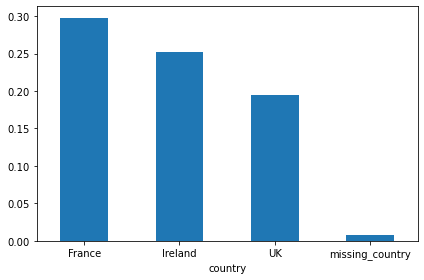

In [8]:
#Firstly, let's quickly check conversion rate of missing values vs non-missing values
#Group by country and check conversion rate
data.fillna("missing_country").groupby(['country'])['converted'].mean().plot.bar()
plt.xticks(rotation=0)

The most important insights are already here and we can expect to find the same insights in 99% of cases when we are dealing with missing values:

When there are missing values, the main metrics tend to be much worse compared to the rest of the users. This is simply self-selection bias. The least engaged users are typically those who choose to not fill out their profiles or, more generally, to not provide certain information about themselves.

Let’s now build a model to predict conversion rate and see how different strategies work. Firstly we will try to replace missing values with values sampled with replacement from that variable.

Sampling is a sound strategy because it gives higher weight to values that show up the most in the original data. So if UK here is >50% of total events, when we sample with replacement, there is a >50% chance of replacing the missing value with UK.

# Replacing missing values with sampling data

In [10]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
  
#set seed to be able to reproduce the results
np.random.seed(4684)
  
data_replace = data.copy()
  
#split into train and test to avoid overfitting
train, test = train_test_split(data_replace, test_size = 0.34)
train = train.reset_index(drop=True).copy()
test =  test.reset_index(drop=True).copy()
  
#replace NAs with randomly selected countries according to the origianl country distribution
train['country'] = train['country'].fillna(pd.Series(np.random.choice( train['country'].dropna() , size=len(train['country']) )))
test['country'] = test['country'].fillna(pd.Series(np.random.choice( test['country'].dropna() , size=len(test['country']) )))
  
#create dummies
train = pd.get_dummies(train, drop_first=True)
test =  pd.get_dummies(test, drop_first=True)
  
#build the model. We will use a RF, but it is the same with any other model. We balance the weights to reduce class 1 errors
rf_replace_sampling = RandomForestClassifier(n_estimators=50, oob_score=True, class_weight={0:1,1:5})
rf_replace_sampling.fit(train.drop('converted', axis=1), train['converted'])
  
#and let's print test set confusion matrix
conf_matrix_sampling = pd.DataFrame(confusion_matrix(test['converted'], rf_replace_sampling.predict(test.drop('converted', axis=1)), labels=[0, 1]))
print(conf_matrix_sampling)

       0      1
0  23926  10233
1   2040   4841


In [11]:
#let's print model accuracy and class errors
class0_error = 1 - conf_matrix_sampling.loc[0,0]/(conf_matrix_sampling.loc[0,0]+conf_matrix_sampling.loc[0,1])
class1_error = 1 - conf_matrix_sampling.loc[1,1]/(conf_matrix_sampling.loc[1,0]+conf_matrix_sampling.loc[1,1])
  
print(pd.DataFrame( {'accuracy': rf_replace_sampling.score(test.drop('converted', axis=1),test['converted']),
                         'class0_error' :[class0_error],
                         'class1_error' :[class1_error]
}))

   accuracy  class0_error  class1_error
0   0.70095       0.29957      0.296469


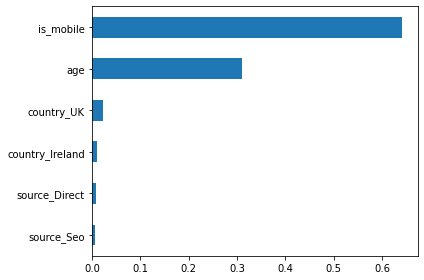

In [12]:
#variable importance
pd.Series(rf_replace_sampling.feature_importances_, index=train.drop('converted', axis=1).columns).sort_values(ascending=True).plot(kind='barh')

# Leave NAs in the data

And let’s now just replace the missing values with “missing_country”.

In [13]:
#replace missing values with "missing_country". Need to convert it to character and then back to factor
data['country'] = data['country'].fillna("missing_country")
  
#create dummy vars
data = pd.get_dummies(data, drop_first=True)
  
#split test/train
#split into train and test to avoid overfitting
train_leave_NA, test_leave_NA = train_test_split(data, test_size = 0.34)
  
#build the model. We will use a RF, but it is the same with any other model. We slightly adjust the weights to reduce class 1 errors
rf_model_leave_NA = RandomForestClassifier(n_estimators=50, oob_score=True, class_weight={0:1,1:5})
rf_model_leave_NA.fit(train_leave_NA.drop('converted', axis=1), train_leave_NA['converted'])
#and let's print test set confusion matrix
conf_matrix_leave_NA = pd.DataFrame(confusion_matrix(test_leave_NA['converted'], rf_model_leave_NA.predict(test_leave_NA.drop('converted', axis=1)), labels=[0, 1]))
print(conf_matrix_leave_NA)

       0     1
0  25300  8680
1   1954  5106


In [14]:
#let's print model accuracy and class errors
class0_error_leave_NA = 1 - conf_matrix_leave_NA.loc[0,0]/(conf_matrix_leave_NA.loc[0,0]+conf_matrix_leave_NA.loc[0,1])
class1_error_leave_NA = 1 - conf_matrix_leave_NA.loc[1,1]/(conf_matrix_leave_NA.loc[1,0]+conf_matrix_leave_NA.loc[1,1])
print(pd.DataFrame( {'accuracy_leave_NA': rf_model_leave_NA.score(test_leave_NA.drop('converted', axis=1),test_leave_NA['converted']),
                         'class0_error_leave_NA' :[class0_error_leave_NA],
                         'class1_error_leave_NA' :[class1_error_leave_NA]
}))

   accuracy_leave_NA  class0_error_leave_NA  class1_error_leave_NA
0           0.740887               0.255444               0.276771


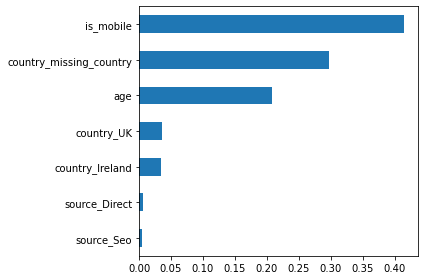

In [15]:
#variable importance
pd.Series(rf_model_leave_NA.feature_importances_, index=train_leave_NA.drop('converted', axis=1).columns).sort_values(ascending=True).plot(kind='barh')

As we can see by comparing the two variable importance plots, the dummy variable “missing_country” is extremely important by itself. By removing it, we would be losing crucial information used by the model

Interestingly, the importance of the other country levels (UK and Ireland) goes down when we replace the missing values by sampling. This is because we “polluted” their information by adding new events with totally different distribution, i.e. much lower conversion rate. So we made those segments noisier and the model is having a harder time extracting information out of them

The effect of those 2 points above is that the model with “missing_country” does significantly better than the one where we replaced NAs by sampling. Accuracy, class 0 error, and class 1 error are all significantly better when using “missing_country”.

 Always leave NAs in our data if the distribution of NAs is different compared to the distribution of that variable. This happens basically always if NAs are not random. The most common reason to have NAs is self-selection bias where the user chooses to not provide certain information

 If the variable is numeric, replace NAs with a very large/small number clearly outside of that variable distribution. But then make sure to use a model which is not affected by outliers. Say our variable range is between 0-100. we can then code the NAs as 10^6. Then use a tree-based classifier. That way it can create a split just for the NAs, something like var X > 10^5. If we used a regression, we would be in trouble since it would try to find a coefficient that can actually fit through the 10^6 points as well.